In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces

In [2]:
grid = np.zeros((3, 3))
print(grid)

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


In [3]:
pos1 = [0, 0]
pos2 = [2, 2]

grid[tuple(pos1)] = 1
grid[tuple(pos2)] = 0.5

print(grid)

[[1.  0.  0. ]
 [0.  0.  0. ]
 [0.  0.  0.5]]


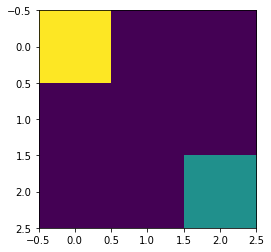

In [4]:
plt.imshow(grid)

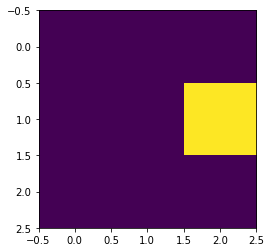

<IPython.core.display.Javascript object>

In [5]:
from google.colab import widgets
import time

output_grid = widgets.Grid(1, 1)
for _ in range(5):
  grid = np.zeros((3, 3))
  grid[np.random.randint(3), np.random.randint(3)] = 1
  with output_grid.output_to(0, 0):
    output_grid.clear_cell()
    plt.imshow(grid)
  time.sleep(1)

In [7]:
class GridEnvironment(gym.Env):
  metadata = { 'render.modes': []}

  def __init__(self):
    self.observation_space = spaces.Discrete(9)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = 5

  def reset(self):
    self.timestep = 0
    self.agent_pos = [0, 0]
    self.goal_pos = [2, 2]
    self.state = np.zeros((3, 3))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()
    return observation

  def step(self, action):
    self.state = np.random.choice(self.observation_space.n)
    if action == 0:
      self.agent_pos[0] += 1
    if action == 1:
      self.agent_pos[0] -= 1
    if action == 2:
      self.agent_pos[1] += 1
    if action == 3:
      self.agent_pos[1] -= 1
    
    self.agent_pos = np.clip(self.agent_pos, 0, 2)
    self.agent_pos = np.clip(self.agent_pos, 0, 2)
    self.state = np.zeros((3,3))
    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.5
    observation = self.state.flatten()

    reward = 0
    if (self.agent_pos == self.goal_pos).all():
      reward = 1

    self.timestep += 1
    done = True if self.timestep >= self.max_timesteps else False
    info = {}

    return observation, reward, done, info

  def render(self):
    plt.imshow(self.state)

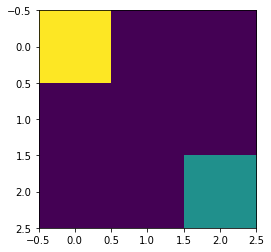

In [8]:
env = GridEnvironment()
obs = env.reset()
env.render()

Reward:  0


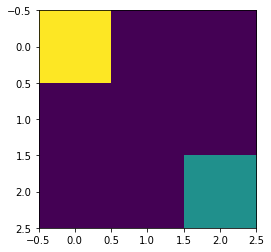

In [10]:
action = 1
observation, reward, done, _ = env.step(action)
env.render()
print('Reward: ', reward)